In [1]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist as mnist
from keras import backend as Keras
from keras.layers import Dense, Dropout
from keras.objectives import categorical_crossentropy
from keras.metrics import categorical_accuracy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

Using TensorFlow backend.


In [2]:
%matplotlib inline

#### Dataset info

In [3]:
# source: http://yann.lecun.com/exdb/mnist/
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10

#### Loading files
Data is already preprocessed, shuffled and normalized.

In [4]:
mnist_dataset = mnist.input_data.read_data_sets('tensorflow/examples/tutorials/mnist', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting tensorflow/examples/tutorials/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting tensorflow/examples/tutorials/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tensorflow/examples/tutorials/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tensorflow/examples/tutorials/mnist/t10k-labels-idx1-ubyte.gz


#### Divide data

In [5]:
trainX = mnist_dataset.train.images
valX = mnist_dataset.validation.images
testX = mnist_dataset.test.images

trainY = mnist_dataset.train.labels.astype(np.float32)
valY = mnist_dataset.validation.labels.astype(np.float32)
testY = mnist_dataset.test.labels.astype(np.float32)

In [6]:
TRAIN_IMAGES_NUM = trainX.shape[0]
TEST_IMAGES_NUM = testX.shape[0]

#### Present data

In [7]:
def show_digit(trainX, trainY, index):
    image = trainX[index].reshape([IMAGE_WIDTH, IMAGE_HEIGHT])
    label = trainY[index]
    plt.title("Training data, index: {},  Label: {}".format(index, label))
    plt.imshow(image, cmap="gray_r")
    plt.show()

trainX shape: (55000, 784)
trainY shape: (55000, 10)
valX shape: (5000, 784)
valY shape: (5000, 10)
testX shape: (10000, 784)
testY shape: (10000, 10)


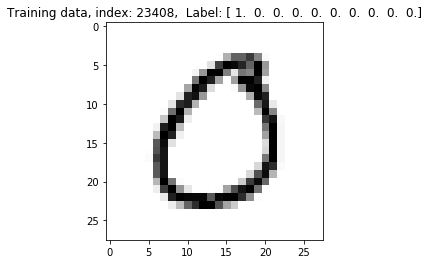

In [8]:
print("trainX shape: " + str(trainX.shape))
print("trainY shape: " + str(trainY.shape))
print("valX shape: " + str(valX.shape))
print("valY shape: " + str(valY.shape))
print("testX shape: " + str(testX.shape))
print("testY shape: " + str(testY.shape))
show_digit(trainX, trainY, np.random.randint(1, TRAIN_IMAGES_NUM + 1))

#### Neural Network preparation

In [9]:
input_nodes = IMAGE_WIDTH * IMAGE_HEIGHT
hidden_layer_1_nodes = 300
hidden_layer_2_nodes = 75
output_layer_nodes = NUM_LABELS

In [10]:
# reset tensorflow graph
tf.reset_default_graph()

# placeholders for inputs, labels and learning rate
inputs_ = tf.placeholder(tf.float32, [None, input_nodes], name="inputs")
targets_ = tf.placeholder(tf.float32, [None, output_layer_nodes], name="targets")
learning_rate_ = tf.placeholder(tf.float32, None, name="learning_rate")
keep_prob_ = tf.placeholder(tf.float32, name="keep_prob")

# layers (wrapped with keras)
input_to_h1_layer = Dense(hidden_layer_1_nodes, activation='relu')(inputs_)  
input_to_h1_layer = tf.nn.dropout(input_to_h1_layer, keep_prob_)

# I use tf.nn.dropout instead of keras.layers.Dropout as it isn't currently well connected with
# tf workflow, it requires float instead of tensor, furthermore we need to play with K.set_learning_phase() value
# and make sure to switch it when we use train to 1 for train and 0 for val set
# source: https://github.com/fchollet/keras/issues/3823

h1_to_h2_layer = Dense(hidden_layer_2_nodes, activation='relu')(input_to_h1_layer)
h1_to_h2_layer = tf.nn.dropout(h1_to_h2_layer, keep_prob_)

h2_to_output = Dense(output_layer_nodes, activation='softmax')(h1_to_h2_layer)

#### Loss and accuracy assessment

In [11]:
# loss function (tf.nn.softmax_cross_entropy_with_logits replaced with keras categorical_crossentropy)
loss_function = tf.reduce_mean(categorical_crossentropy(targets_, h2_to_output))

# gradient descent optimiser
optimizer = tf.train.GradientDescentOptimizer(learning_rate_).minimize(loss_function)

# accuracy 
# correct_prediction = tf.equal(tf.argmax(h2_to_o_layer_logits, 1), tf.argmax(targets_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# replaced with keras categorical_accuracy -> returns binary value per sample instead of percentage value
accuracy = categorical_accuracy(targets_, h2_to_output)

#### Batch preparation

My own implementation:

In [12]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

In [13]:
# divide trainX, trainY data into batches of size 128, data is copied
mini_batches_example = prepare_mini_batches(trainX, trainY, 128)

# pop next batches
exampleX_batches, exampleY_batches = mini_batches_example.pop()
print("Input data mini-batch: " + str(exampleX_batches.shape))
print("Input data labels mini-batch: " + str(exampleY_batches.shape))

Input data mini-batch: (128, 784)
Input data labels mini-batch: (128, 10)


Similar but <u>NOT THE SAME</u> result could be achieved by using `mnist_dataset.train` object.

In [14]:
# fetching next 128 size RANDOM batches from data in mnist_dataset.traing
tf_exampleX_batches, tf_exampleY_batches = mnist_dataset.train.next_batch(128)
print("Input data mini-batch: " + str(tf_exampleX_batches.shape))
print("Input data labels mini-batch: " + str(tf_exampleY_batches.shape))

Input data mini-batch: (128, 784)
Input data labels mini-batch: (128, 10)


Main difference between two approaches is:

a) With my implementation you make sure that if you iterate over *mini_batches* received from *prepare_mini_batches* function - your whole train data will be inserted into net but with random order. 

b) With tensorflow implementation you simply receive randomly picked *batch_size* samples. That way it is possible that some of samples from train set will enter net more often than others.

#### Hyperparameters

In [15]:
epochs = 65
batch_size = 128
learning_rate = 0.05
keep_prob = 0.5

####  Training cycle

In [16]:
session = tf.Session()
Keras.set_session(session)

In [17]:
info = {'train':[], 'validation':[], 'train_acc':[], 'validation_acc':[]}

session.run(tf.global_variables_initializer())
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(trainX, trainY, batch_size)

    epoch_losses = []
    epoch_accuracy = []
    while mini_batches:
        data_inputs, data_labels = mini_batches.pop()

        session.run(optimizer,
                    feed_dict={inputs_: data_inputs, 
                               targets_: data_labels, 
                               learning_rate_: learning_rate,
                               keep_prob_: keep_prob})

        batch_loss = session.run(loss_function, feed_dict={inputs_: data_inputs, 
                                                           targets_: data_labels,
                                                           keep_prob_: 1.})

        batch_acc = session.run(accuracy, feed_dict={inputs_:data_inputs, 
                                                     targets_: data_labels,
                                                     keep_prob_: 1.})
        batch_acc = np.mean(batch_acc)

        epoch_losses.append(batch_loss)
        epoch_accuracy.append(batch_acc)

    train_loss = np.mean(epoch_losses)
    info['train'].append(train_loss)

    train_accuracy = np.mean(epoch_accuracy)
    info['train_acc'].append(train_accuracy)

    val_loss = session.run(loss_function, feed_dict={inputs_: valX, 
                                                     targets_: valY,
                                                     keep_prob_: 1.})
    info['validation'].append(val_loss)

    val_accuracy = session.run(accuracy, feed_dict={inputs_: valX, 
                                                    targets_: valY,
                                                    keep_prob_: 1.})
    val_accuracy = np.mean(val_accuracy)
    info['validation_acc'].append(val_accuracy)

    print("Epoch: " + str(epoch + 1) + "/" + str(epochs) + ":\n"
          + "      - Training loss: " + str(train_loss) + " (acc: " + str(train_accuracy) + ")\n"
          + "      - Validation loss: " + str(val_loss) + " (acc: " + str(val_accuracy) + ")")

Epoch: 1/65:
      - Training loss: 0.701786 (acc: 0.833224)
      - Validation loss: 0.353318 (acc: 0.9048)
Epoch: 2/65:
      - Training loss: 0.299679 (acc: 0.9149)
      - Validation loss: 0.256557 (acc: 0.9308)
Epoch: 3/65:
      - Training loss: 0.235336 (acc: 0.932128)
      - Validation loss: 0.213685 (acc: 0.9398)
Epoch: 4/65:
      - Training loss: 0.198283 (acc: 0.942144)
      - Validation loss: 0.187059 (acc: 0.9464)
Epoch: 5/65:
      - Training loss: 0.173558 (acc: 0.949173)
      - Validation loss: 0.170338 (acc: 0.952)
Epoch: 6/65:
      - Training loss: 0.154555 (acc: 0.955037)
      - Validation loss: 0.153054 (acc: 0.9556)
Epoch: 7/65:
      - Training loss: 0.139181 (acc: 0.959189)
      - Validation loss: 0.141748 (acc: 0.959)
Epoch: 8/65:
      - Training loss: 0.127466 (acc: 0.962868)
      - Validation loss: 0.133256 (acc: 0.9612)
Epoch: 9/65:
      - Training loss: 0.11704 (acc: 0.966073)
      - Validation loss: 0.127443 (acc: 0.9632)
Epoch: 10/65:
      - Tr

#### Results

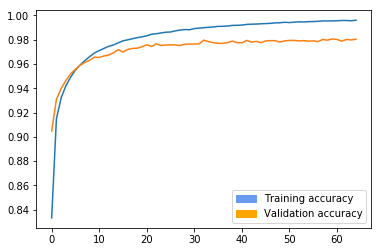

In [18]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['validation_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

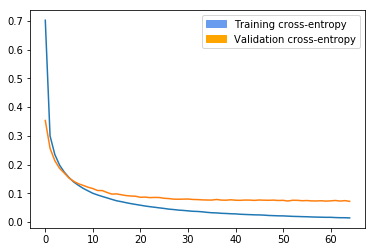

In [19]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train'], label='Training loss')
ax2.plot(info['validation'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

In [20]:
test_accuracy = accuracy.eval(session=session, 
                              feed_dict={inputs_: testX, targets_: testY, keep_prob_: 1.})
test_accuracy = np.mean(test_accuracy)
print("Test dataset accuracy: " + str(test_accuracy))

Test dataset accuracy: 0.9823


In [21]:
session.close()